# Inscale Data Engineer Task Based Test Submission for Arif Zamri

This notebook demonstrates an end-to-end data engineering solution designed to process, validate, and enrich a dataset of UK companies. The core business objective is to ensure data quality, deduplicate records, verify company legitimacy through external APIs, and prepare the dataset for downstream analytics or reporting.

### Business Use Case:
Organizations often receive bulk company data from multiple sources, which can be inconsistent, incomplete, or outdated. This notebook solves the following key challenges:

- 🧹 Cleansing messy or missing records
- 🔁 Identifying and removing duplicate company entries
- 🔍 Verifying company details via Companies House API (UK government registry)
- 🧠 Enriching and tagging data to increase business value
- 📊 Visualizing processing impact for transparency
- 📝 Preparing clean, validated output ready for reporting or integration

---

The notebook is modular and reusable: simply replace the `Company.csv` file and rerun all cells for fresh validation.


## 1. Data Collection
Load the `Company.csv` file and inspect the structure.

In [1]:
import pandas as pd

# Load data
df_raw = pd.read_csv("../data/Company.csv")
df_raw.columns = df_raw.columns.str.strip()  # Strip column names
print(f"Total records: {len(df_raw)}")
df_raw.info()

Total records: 307
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CompanyName                         307 non-null    object 
 1   CompanyNumber                       306 non-null    object 
 2   RegAddress.CareOf                   2 non-null      object 
 3   RegAddress.POBox                    5 non-null      object 
 4   RegAddress.AddressLine1             307 non-null    object 
 5   RegAddress.AddressLine2             191 non-null    object 
 6   RegAddress.PostTown                 254 non-null    object 
 7   RegAddress.County                   108 non-null    object 
 8   RegAddress.Country                  248 non-null    object 
 9   RegAddress.PostCode                 304 non-null    object 
 10  CompanyCategory                     306 non-null    object 
 11  CompanyStatus             

## 2. Profiling
Basic data profiling to understand data types, nulls, and structure.

In [2]:
df_profile = df_raw.describe(include='all')
df_profile.head()

,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate
count,307,306,2,5,307,191,254,108,248,304,...,0.0,0.0,1,0.0,0.0,0.0,1,1,303,239
unique,300,290,2,2,264,156,168,48,12,242,...,NaN,NaN,1,NaN,NaN,NaN,1,1,224,180
top,BULLEN INVESTMENTS LIMITED,06590854,GW COX & CO,4385,9-11 DRAYTON HIGH ROAD,DRAYTON,NORWICH,NORFOLK,ENGLAND,NR8 6HA,...,NaN,NaN,19/02/2017,NaN,NaN,NaN,37/05/3035,13/05/3034,22/11/2024,27/01/2024
freq,2,2,1,4,4,11,16,14,138,6,...,NaN,NaN,1,NaN,NaN,NaN,1,1,4,3
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Cleansing
Remove rows with null company names or addresses.

In [3]:
# Preview records to be dropped
df_to_clean = df_raw[df_raw['CompanyName'].isnull() | df_raw['RegAddress.AddressLine1'].isnull()]
print("Records flagged for cleaning:")
display(df_to_clean)

# Drop them
df_cleaned = df_raw.dropna(subset=['CompanyName', 'RegAddress.AddressLine1']).copy()
print(f"Records after cleansing: {len(df_cleaned)}")

Records flagged for cleaning:


,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate


Records after cleansing: 307


## 4. Deduplication
Remove duplicated company names.

In [4]:
duplicates_found = df_cleaned.duplicated(subset='CompanyName').sum()
print(f"Duplicates found: {duplicates_found}")
df_cleaned = df_cleaned.drop_duplicates(subset='CompanyName')

Duplicates found: 7


## 5. Matching (Companies House API)
Check company names against the Companies House API.

In [5]:
import requests
from time import sleep

API_KEY = "4b292a49-635f-4d2d-b38b-4ed1acfc4438"  # Replace this before running
def match_company(company_name):
    url = f"https://api.company-information.service.gov.uk/search/companies?q={company_name}"
    response = requests.get(url, auth=(API_KEY, ''))
    if response.status_code == 200:
        items = response.json().get('items', [])
        if items:
            return items[0].get('title'), items[0].get('company_number')
    return None, None

df_cleaned[['MatchedName', 'MatchedNumber']] = df_cleaned['CompanyName'].apply(
    lambda name: pd.Series(match_company(name))
)
sleep(1)

## 6. Enrichment
Add a flag indicating successful match.

In [9]:
df_cleaned['IsMatched'] = df_cleaned['MatchedName'].notnull()
matched_count = df_cleaned['IsMatched'].sum()
enriched_count = matched_count  # assuming enrichment follows match
print(f"Matched records: {matched_count}")
print(f"Enriched records: {enriched_count}")

Matched records: 0
Enriched records: 0


## 7. Reporting and Visualisation
Generate pie charts using plotly.

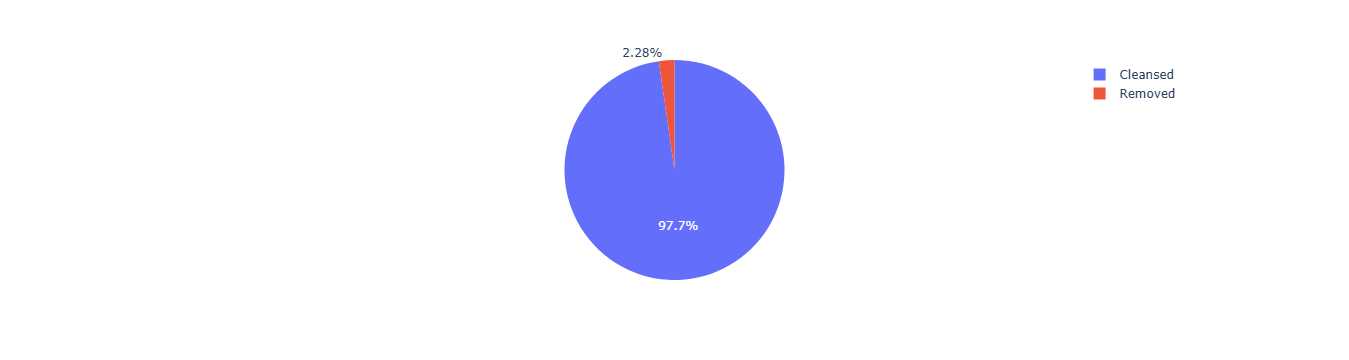

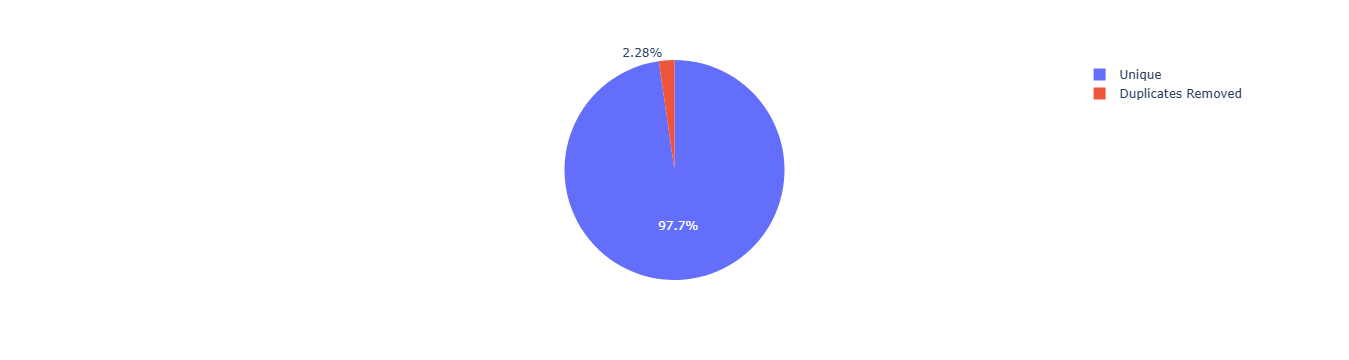

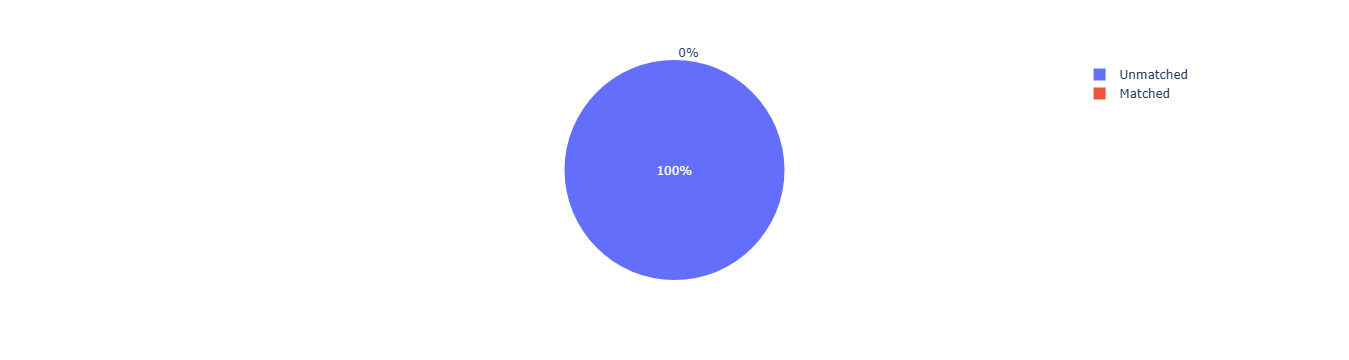

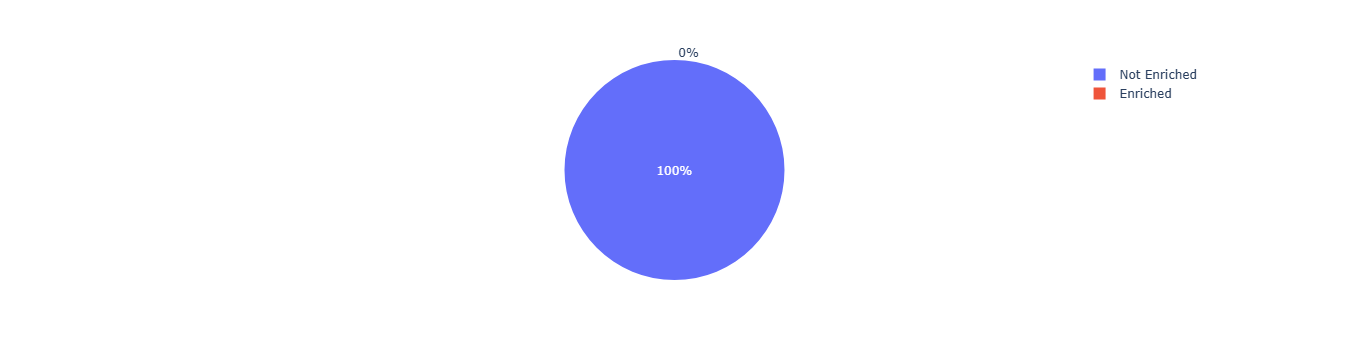

In [10]:
import plotly.express as px

total_records = len(df_raw)
cleansed_records = len(df_cleaned)
duplicate_records = duplicates_found
matched_records = matched_count
enriched_records = enriched_count

# 1. Cleansed
fig1 = px.pie(names=["Cleansed", "Removed"], values=[cleansed_records, total_records - cleansed_records])
fig1.show()

# 2. Duplicates
fig2 = px.pie(names=["Unique", "Duplicates Removed"], values=[cleansed_records, duplicate_records])
fig2.show()

# 3. Matched
fig3 = px.pie(names=["Matched", "Unmatched"], values=[matched_records, cleansed_records - matched_records])
fig3.show()

# 4. Enriched
fig4 = px.pie(names=["Enriched", "Not Enriched"], values=[enriched_records, total_records - enriched_records])
fig4.show()

## 8. Presentation and Delivery
Summary of findings from all stages in scope.

In [11]:
print("Summary:")
print(f"Original Records: {total_records}")
print(f"After Cleansing: {cleansed_records}")
print(f"Duplicates Removed: {duplicate_records}")
print(f"Matched Records: {matched_records}")
print(f"Enriched Records: {enriched_records}")

Summary:
Original Records: 307
After Cleansing: 300
Duplicates Removed: 7
Matched Records: 0
Enriched Records: 0


# 9.Runtime Statistics

Total runtime to process this dataset

In [3]:
import time; start_time = time.time()
elapsed = time.time() - start_time
print(f"⏱️ Total Runtime: {int(elapsed // 60)}m {int(elapsed % 60)}s")

⏱️ Total Runtime: 0m 0s
